# Temperature and metallic systems

In this example we consider the modeling of a magnesium lattice
as a simple example for a metallic system.
For our treatment we will use the PBE exchange-correlation functional.
First we import required packages and setup the lattice.

In [1]:
using DFTK
using Plots

a = 3.01794  # bohr
b = 5.22722  # bohr
c = 9.77362  # bohr
lattice = [[-a -a  0]; [-b  b  0]; [0   0 -c]]
Mg = ElementPsp(:Mg, psp=load_psp("hgh/pbe/Mg-q2"))
atoms = [Mg => [[2/3, 1/3, 1/4], [1/3, 2/3, 3/4]]];

Next we build the PBE model and discretize it.
Since magnesium is a metal we apply a small smearing
temperature to ease convergence using the Fermi-Dirac
smearing scheme. Note that both the `Ecut` is too small
as well as the minimal ``k``-point spacing
`kspacing` far too large to give a converged result.
These have been selected to obtain a fast execution time.

In [2]:
kspacing = 0.5      # Minimal spacing of k-points,
#                    in units of wavevectors (inverse Bohrs)
Ecut = 5            # kinetic energy cutoff in Hartree
temperature = 0.01  # Smearing temperature in Hartree

kgrid = kgrid_size_from_minimal_spacing(lattice, kspacing)
kgrid_size_from_minimal_spacing(lattice, kspacing)
model = model_DFT(lattice, atoms, [:gga_x_pbe, :gga_c_pbe];
                  temperature=temperature,
                  smearing=DFTK.Smearing.FermiDirac())
basis = PlaneWaveBasis(model, Ecut, kgrid=kgrid);

Finally we run the SCF. Even though two magnesium atoms in
our pseudopotential model only result in four valence electrons being explicitly
treated, we still solve for eight bands in order to capture
the partial occupations beyond the Fermi level due to
the employed smearing scheme.

In [3]:
scfres = self_consistent_field(basis, n_bands=8);

Iter   Free energy        ρout-ρin
----   -----------        --------
  1    -1.743113476597    5.204393E-02
  2    -1.743601957483    1.748078E-03
  3    -1.743615361100    3.981256E-04
  4    -1.743614168637    5.423665E-04
  5    -1.743616547666    1.749804E-05
  6    -1.743616550910    9.187734E-07


In [4]:
scfres.energies

Energy breakdown:
    Kinetic             0.7450656 
    AtomicLocal         0.3193223 
    AtomicNonlocal      0.3192693 
    Ewald               -2.1544222
    PspCorrection       -0.1026056
    Hartree             0.0061604 
    Xc                  -0.8615677
    Entropy             -0.0148387

    total               -1.743616550910


The fact that magnesium is a metal is confirmed
by plotting the density of states around the Fermi level.

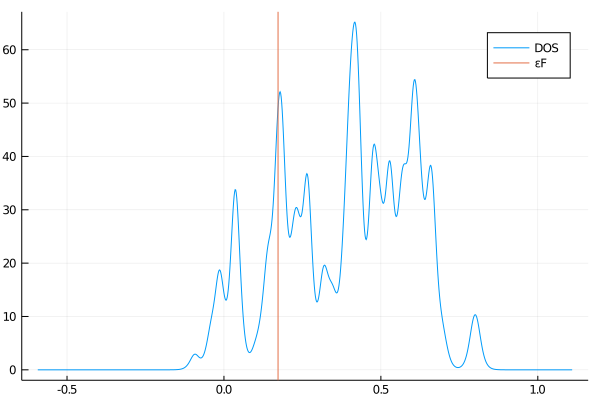

In [5]:
εs = range(minimum(minimum(scfres.eigenvalues)) - .5,
           maximum(maximum(scfres.eigenvalues)) + .5, length=1000)
Ds = DOS.(εs, Ref(basis), Ref(scfres.eigenvalues))
q = plot(εs, Ds, label="DOS")
vline!(q, [scfres.εF], label="εF")